In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm
from DLtools.Data import load_data,instant_data,intersection
from DLtools.evaluation_rec import real_eva_error, error_rec


In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [3]:
save_path='/home/song/Public/Song/Work/Thesis/output/Linear/hourly/'

# Load data

In [4]:
# loaddata = load_data()
# ame = loaddata.df_rain
# kawa = loaddata.df_water
# tenki = loaddata.df_weather
# dam = loaddata.df_dam

# df_d = loaddata.daily()
# df_h = loaddata.hourly()


In [5]:
loading = instant_data()
df_h = loading.hourly_instant()

In [6]:
# data=df_h["2013-01-01":"2017-12-31"].interpolate(limit=360).fillna(0)
data = df_h['2013-01-01':'2017-12-31'].apply(lambda x: x.fillna(x.mean()),axis=0)
TARGET = 'CPY015_wl'

In [7]:
#Shif target date
n_out = 7*24
data[TARGET]=data[TARGET].shift(-n_out)
data = data.dropna()

# MAR feature selection

In [8]:
mar = pd.read_csv('/home/song/Public/Song/Work/Thesis/featurelist_MAR_hourly_7d.csv')
col = [i for i in data.columns]
select_col = intersection(col,mar['feature'])




In [9]:

select_col.append(TARGET) # add target
data = data[select_col]

# Feature selection

In [10]:
def high_corr(data,threshold=.95):
    """Eliminate first columns with high corr"""
    
    corr_matrix = data.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [11]:
def corr_w_Y(data,target,threshold= 0.3):
    # correlation 
    corr_test = data.corr(method='pearson')[target]
    corr_test = corr_test[(corr_test> threshold) | (corr_test< -threshold) ]
    corr_test = corr_test.sort_values(ascending=False)
    #corr_test =corr_test[1:] # eliminate Target it own
    return corr_test

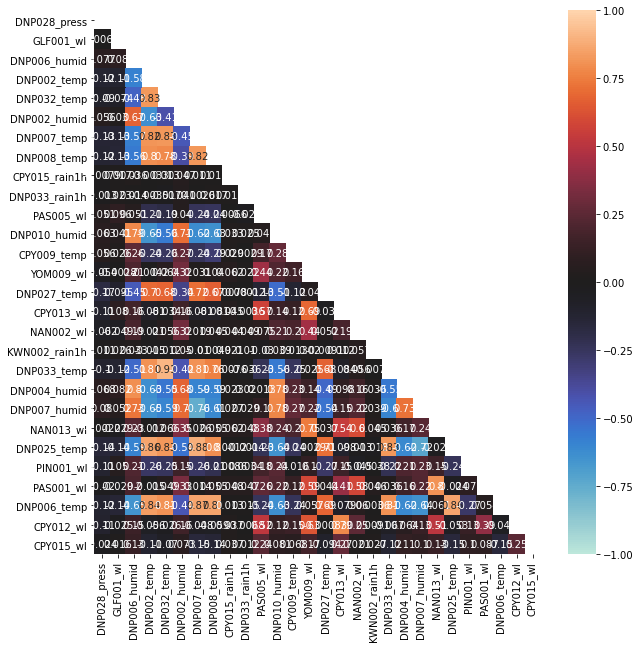

In [12]:
# col_feature = corr_w_Y(data,TARGET,0.5).index
# data = data[col_feature]

# high_col = high_corr(data.iloc[:,1:]) #exclude target it own
# data.drop(columns=high_col,inplace=True)
corr = data.corr()

plt.subplots(figsize=(10,10))
mask = np.triu(data.corr())
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0,mask=mask)
plt.savefig(save_path+'Corr_timelag{}.png'.format(n_out), dpi=300, bbox_inches='tight')

# Linear Regression

In [13]:
X = data.drop(columns=[TARGET])
Y = data[TARGET]

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, shuffle=False)

In [14]:
regr = linear_model.LinearRegression()
regr.fit(trainX,trainY)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 3.215525495622083
Coefficients: 
 [-0.00212785 -0.03697269  0.0021498   0.01104215  0.0342431   0.0004405
 -0.03095513 -0.0117023   0.01635772  0.01430597  0.00906738 -0.00380024
  0.00017709  0.00613235  0.00070085  0.14807349 -0.0104994   0.01738529
 -0.00672042  0.00355406 -0.00635904  0.01108051 -0.02444032  0.03688258
 -0.02336437  0.0040091   0.11047037]


In [15]:
# with statsmodels
#X = sm.add_constant(trainX) # adding a constant
 
#model = sm.OLS(trainY, trainX).fit()
#predictions = model.predict(trainX) 
#model.summary()

# Evaluation

In [16]:
trainPredict = regr.predict(trainX)
testPredict = regr.predict(testX)

mse, nse,r2 = real_eva_error(trainY, trainPredict)
Tmse, Tnse,Tr2 = real_eva_error(testY, testPredict)

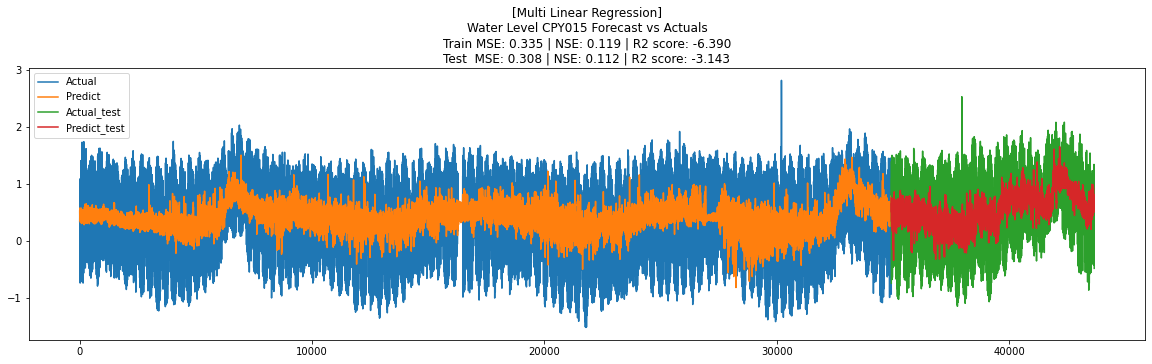

<Figure size 432x288 with 0 Axes>

In [17]:
index = np.arange(len(trainY)+len(testY))

Y= pd.Series(data=trainY.values,index=index[:len(trainY)])
Yhat = pd.Series(data=(trainPredict),index=index[:len(trainY)])
Y_t= pd.Series(data=testY.values,index=index[-len(testY):])
Yhat_t = pd.Series(data=(testPredict),index=index[-len(testY):])

plt.figure(figsize=(20,5))
plt.plot(Y, label = "Actual")
plt.plot(Yhat, label = "Predict")

plt.plot(Y_t, label = "Actual_test")
plt.plot(Yhat_t, label = "Predict_test")
plt.title('[Multi Linear Regression]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))
plt.legend()
plt.show()

plt.savefig(save_path+'result_MAR_Linear.png', dpi=300, bbox_inches='tight')



# fig,ax = plt.subplots(2,1,figsize=(20,5),constrained_layout=True)
# ax[0].plot(Y,label="Actual")
# ax[0].plot(Yhat,label="Predict")
# ax[0].set_ylabel('Water level(mm)')
# ax[0].legend()

# ax[1].plot(Y_t,label="Actual")
# ax[1].plot(Yhat_t,label="Predict")
# ax[1].set_ylabel('Water level(mm)')
# ax[1].legend()

# plt.show()
# plt.savefig('output/Linear_fig.png')

Plot

In [18]:
# plt.figure(figsize=(20,5))
# plt.plot(trainY.sort_index(),'.',label="Train_Actual")
# plt.plot(trainPredict.sort_index(),'.',label="Train_Predict")
# plt.plot(testY.sort_index(),'x',label="Test_Actual")
# plt.plot(testPredict.sort_index(),'x',label="Test_Predict")
# plt.title('[Multi Linear Regression *Testonly]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))

# plt.legend()
# plt.show()
# #plt.savefig('output/Linear/result_Linear.png', dpi=300, bbox_inches='tight')

Record

In [19]:
idx=['Modelname','Feature','n_in_time','batchsize','mse','nse','r2','Test_mse','Test_nse','Test_r2','Intercept','Coefficients']
col = ['MultiLinearReg']
error = pd.DataFrame(["MultiLinearReg",[data.columns],"None",'None',mse, nse,r2,Tmse, Tnse,Tr2,[regr.intercept_], [regr.coef_]],index=idx,columns=col)
error.to_csv(save_path+'evaluation_MAR_Linear.csv')

# LOOP

In [20]:
#n_out = 7

error=pd.DataFrame()
for n_out in range(1,8):
    data=df_d["2013-01-01":"2017-12-31"].interpolate(limit=360).fillna(0)
    TARGET = 'CPY015_wl'
    data[TARGET]=data[TARGET].shift(-n_out)
    data = data.dropna()
    col_feature = corr_w_Y(data,TARGET,0.5).index
    data = data[col_feature]

    high_col = high_corr(data.iloc[:,1:]) #exclude target it own
    data.drop(columns=high_col,inplace=True)
    corr = data.corr()

    plt.subplots(figsize=(10,10))
    mask = np.triu(data.corr())
    sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0,mask=mask)
    plt.savefig('output/Linear/Corr_timelag{}.png'.format(n_out), dpi=300, bbox_inches='tight')
    X = data.drop(columns=[TARGET]).interpolate(limit=500)
    Y = data[TARGET].interpolate(limit=500)

    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(trainX,trainY)
    trainPredict = regr.predict(trainX)
    train_set_mse = (mean_squared_error(trainY, trainPredict))
    train_set_r2 = r2_score(trainY, trainPredict)
    print(train_set_mse)
    print(train_set_r2)

    testPredict = regr.predict(testX)
    test_set_mse = ((mean_squared_error(testY, testPredict)))
    test_set_r2 = r2_score(testY, testPredict)
    print(test_set_mse)
    print(test_set_r2)


    mse, nse,r2 = real_eva_error(trainY, trainPredict)
    Tmse, Tnse,Tr2 = real_eva_error(testY, testPredict)
    index = np.arange(len(trainY)+len(testY))

    Y= pd.Series(data=trainY.values,index=index[:len(trainY)])
    Yhat = pd.Series(data=(trainPredict),index=index[:len(trainY)])
    Y_t= pd.Series(data=testY.values,index=index[-len(testY):])
    Yhat_t = pd.Series(data=(testPredict),index=index[-len(testY):])

    plt.figure(figsize=(20,5))
    plt.plot(Y, label = "Actual")
    plt.plot(Yhat, label = "Predict")

    plt.plot(Y_t, label = "Actual_test")
    plt.plot(Yhat_t, label = "Predict_test")
    plt.title('[Multi Linear Regression] ahead {} day'.format(n_out)+'\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))
    plt.legend()
    plt.show()
    plt.savefig('output/Linear/result_Linear_{}d.png'.format(n_out), dpi=300, bbox_inches='tight')

    idx=['Modelname','Feature','n_in_time','batchsize','mse','nse','r2','Test_mse','Test_nse','Test_r2','Intercept','Coefficients']
    col = ['MultiLinearReg']
    _df = pd.DataFrame(["MultiLinearReg",[data.columns],"None",'None',mse, nse,r2,Tmse, Tnse,Tr2,[regr.intercept_], [regr.coef_]],index=idx,columns=col)
    error = pd.concat([error,_df],axis=1)
    error.to_csv('output/Linear/evaluation_Linear_{}d.csv'.format(n_out))

NameError: name 'df_d' is not defined

# VAR model

In [21]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [26]:
# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# grangers_causation_matrix(data, variables = data.columns)        

In [22]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

/home/song/anaconda3/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:569: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
DNP028_press ::  92610.75  > nan       =>   False
GLF001_wl ::  81100.49  > nan       =>   False
DNP006_humid ::  73269.35  > nan       =>   False
DNP002_temp ::  67007.75  > nan       =>   False
DNP032_temp ::  60871.01  > nan       =>   False
DNP002_humid ::  54857.68  > nan       =>   False
DNP007_temp ::  49216.66  > nan       =>   False
DNP008_temp ::  44046.14  > nan       =>   False
CPY015_rain1h ::  38901.69  > nan       =>   False
DNP033_rain1h ::  33999.06  > nan       =>   False
PAS005_wl ::  29306.31  > nan       =>   False
DNP010_humid ::  24901.66  > nan       =>   False
CPY009_temp ::  20891.21  > nan       =>   False
YOM

In [23]:
nobs = 4
train, test = data[0:-nobs], data[-nobs:]

In [24]:
model = VAR(train)
model_fit = model.fit()

In [25]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,41.94,41.95,1.644e+18,41.95
1,-8.753,-8.591,0.0001581,-8.702
2,-12.78,-12.46,2.825e-06,-12.68
3,-13.19,-12.71,1.875e-06,-13.04
4,-13.37,-12.74,1.557e-06,-13.17
5,-13.56,-12.77,1.291e-06,-13.31
6,-13.80,-12.85*,1.020e-06,-13.50
7,-13.95,-12.85,8.772e-07,-13.60
8,-14.09,-12.84,7.603e-07,-13.69
9,-14.24,-12.83,6.568e-07,-13.79


In [26]:
model_fitted = model.fit(4)
model_fitted.summary()

7.360           0.000
L1.DNP032_temp           0.000418         0.000510            0.819           0.413
L1.DNP002_humid         -0.000231         0.000126           -1.835           0.067
L1.DNP007_temp          -0.002361         0.000467           -5.054           0.000
L1.DNP008_temp          -0.001957         0.000540           -3.623           0.000
L1.CPY015_rain1h         0.000541         0.000511            1.060           0.289
L1.DNP033_rain1h         0.001741         0.000556            3.133           0.002
L1.PAS005_wl            -0.002977         0.001878           -1.585           0.113
L1.DNP010_humid         -0.000112         0.000100           -1.127           0.260
L1.CPY009_temp           0.000824         0.000220            3.742           0.000
L1.YOM009_wl             0.000124         0.003601            0.035           0.972
L1.DNP027_temp          -0.000465         0.000270           -1.724           0.085
L1.CPY013_wl             0.045144         0.005018    

In [27]:
lag_order = model_fitted.k_ar   
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = test.values[-lag_order:]
forecast_input

4


array([[ 9.35630000e+02,  1.56000000e+00,  8.98300000e+01,
         2.20500000e+01,  2.15600000e+01,  6.51700000e+01,
         2.30300000e+01,  1.91100000e+01,  0.00000000e+00,
         0.00000000e+00,  4.22200000e+01,  8.71700000e+01,
         3.18500000e+01,  2.68833333e+01,  2.20500000e+01,
         9.80000000e-01,  1.97355000e+02,  0.00000000e+00,
         1.81300000e+01,  7.53646592e+01,  7.75000000e+01,
         4.13300000e+01,  2.64600000e+01,  1.19166667e+02,
         1.40308622e+02,  1.96000000e+01,  1.20166667e+00,
        -3.83333333e-02],
       [ 9.36710000e+02,  1.26833333e+00,  9.48300000e+01,
         2.15600000e+01,  2.05800000e+01,  6.36700000e+01,
         2.20500000e+01,  1.86200000e+01,  0.00000000e+00,
         0.00000000e+00,  4.22200000e+01,  9.11700000e+01,
         3.28300000e+01,  2.68900000e+01,  2.15600000e+01,
         9.98333333e-01,  1.97360000e+02,  0.00000000e+00,
         1.76400000e+01,  7.53646592e+01,  8.15000000e+01,
         4.13300000e+01,  2.40

In [28]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_2d')
df_forecast

,DNP028_press_2d,GLF001_wl_2d,DNP006_humid_2d,DNP002_temp_2d,DNP032_temp_2d,DNP002_humid_2d,DNP007_temp_2d,DNP008_temp_2d,CPY015_rain1h_2d,DNP033_rain1h_2d,...,DNP033_temp_2d,DNP004_humid_2d,DNP007_humid_2d,NAN013_wl_2d,DNP025_temp_2d,PIN001_wl_2d,PAS001_wl_2d,DNP006_temp_2d,CPY012_wl_2d,CPY015_wl_2d
date,,,,,,,,,,,,,,,,,,,,,
2017-12-24 20:00:00,937.139697,0.300645,77.782017,19.068220,18.891805,72.040407,19.944447,16.859891,0.037525,-0.072343,...,17.282835,77.222369,88.206055,41.345033,21.755237,119.702681,140.297733,17.042952,1.293316,-0.351309
2017-12-24 21:00:00,936.980625,0.161930,78.426435,19.019191,18.692422,72.930838,19.449394,16.815759,-0.025087,-0.088847,...,17.542529,77.902245,89.115523,41.352572,21.029310,119.716061,140.293180,16.655664,1.234357,-0.107219
2017-12-24 22:00:00,936.610898,0.164726,77.649327,19.392180,18.891676,73.027530,19.086428,17.149344,-0.055256,-0.045454,...,18.104482,77.974661,89.313011,41.365973,20.860856,119.684872,140.283993,16.604989,1.158262,0.194701
2017-12-24 23:00:00,936.475450,0.298226,76.953467,20.058622,19.609979,72.049985,19.289789,17.698210,-0.070798,-0.041615,...,18.737152,77.712905,88.410086,41.370315,21.155439,119.624950,140.272485,17.025242,1.073779,0.499808


In [29]:
# yhat = model_fit.forecast(model_fit.y, steps=1)
df=data
df_results=df_forecast


fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

KeyError: 'DNP028_press_forecast'